In [15]:
# !pip install kagglehub boto3 mlflow awscli


In [16]:
import os
import numpy as np
import pandas as pd

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Load dataset
path = path = r"../data/"
file_path = os.path.join(path, "YoutubeCommentsDataSet.csv")
df = pd.read_csv(file_path).dropna()
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [18]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df = df[~(df['Comment'].str.strip() == '')]

In [19]:
def map_sentiment(sentiment_text):
    if sentiment_text == 'negative':
        return -1
    elif sentiment_text == 'neutral':
        return 0
    elif sentiment_text == 'positive':
        return 1
    else:
        return None # Handle unexpected values

df['Sentiment'] = df['Sentiment'].apply(map_sentiment)

In [20]:
# Define the preprocessing function
def preprocess_comment(comment):
    # Convert to lowercase
    comment = comment.lower()

    # Remove trailing and leading whitespaces
    comment = comment.strip()

    # Remove newline characters
    comment = re.sub(r'\n', ' ', comment)

    # Remove non-alphanumeric characters, except punctuation
    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)

    # Remove stopwords but retain important ones for sentiment analysis
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment

In [21]:
# Apply the preprocessing function to the 'Comment' column
df['Comment'] = df['Comment'].apply(preprocess_comment)
df.head()

,Comment,Sentiment
0,let not forget apple pay 2014 required brand n...,0
1,nz 50 retailer dont even contactless credit ca...,-1
2,forever acknowledge channel help lesson idea e...,1
3,whenever go place doesnt take apple pay doesnt...,-1
4,apple pay convenient secure easy use used kore...,1


In [22]:
# Step 1: Vectorize the comments using Bag of Words (CountVectorizer)
vectorizer = CountVectorizer(max_features=10000)  # Bag of Words model with a limit of 1000 features

In [23]:
X = vectorizer.fit_transform(df['Comment']).toarray()
y = df['Sentiment']  # Assuming 'sentiment' is the target variable (0 or 1 for binary classification)

In [24]:
X.shape, y.shape

((17874, 10000), (17874,))

In [25]:
# Set up the MLflow tracking server and create experiment
tracking_uri= r"http://ec2-13-233-44-80.ap-south-1.compute.amazonaws.com:5000" #"http://127.0.0.1:5000" fot mlflow locally
mlflow.set_tracking_uri(tracking_uri) # mlflow in aws
mlflow.set_experiment("Random Forest Classifier Baseline")

KeyboardInterrupt: 

In [ ]:
y[:10]

0        0
1       -1
2        1
3       -1
4        1
        ..
18403    1
18404    1
18405    0
18406    1
18407    1
Name: Sentiment, Length: 17874, dtype: int64

c:\Users\Admin\.conda\envs\mlflow_env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\.conda\envs\mlflow_env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\.conda\envs\mlflow_env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

🏃 View run RandomForest_Baseline_TrainTestSplit at: http://127.0.0.1:5000/#/experiments/1/runs/5a9fa39566874f3ba3bf2e49564a84fc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
Accuracy: 0.6265734265734266


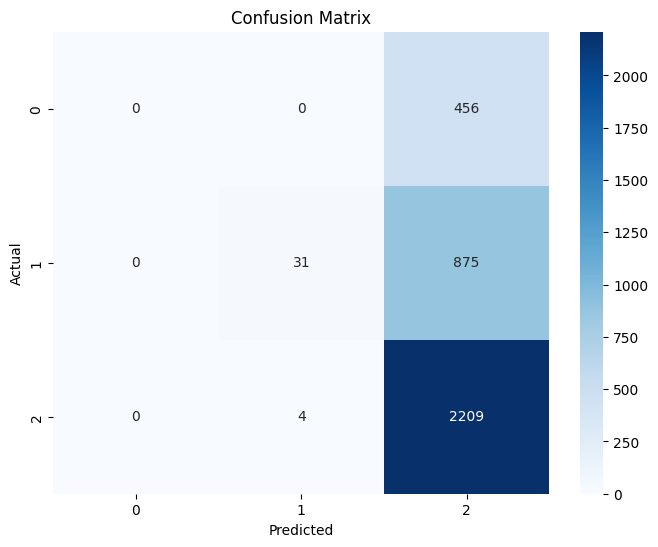

In [ ]:
# Step 1: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Define and train a Random Forest baseline model using a simple train-test split
with mlflow.start_run() as run:
    # Log a description for the run
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    # Add a description
    mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")

    # Log parameters for the vectorizer
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    # Log Random Forest parameters
    n_estimators = 200
    max_depth = 15

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Log metrics for each class and accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("/content/confusion_matrix.png")

    # Log the Random Forest model
    mlflow.sklearn.log_model(model, "random_forest_model")

    # Optionally log the dataset itself (if it's small enough)
    df.to_csv("dataset.csv", index=False)
    mlflow.log_artifact("/content/dataset.csv")

# Display final accuracy
print(f"Accuracy: {accuracy}")